In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [3]:
file_place = r"C:\Users\Conor\DataSets"

Oesophageal_DF = pd.read_pickle(file_place + r"\Oesophageal_raw")

In [4]:
Oesophageal_DF.head()

999.0     1001.0    1003.0    1005.0    1007.0    1009.0  \
New_label Label                                                               
Cancer    OE19   0.001124  0.001416  0.001787  0.002208  0.002671  0.003174   
          OE19   0.029759  0.029642  0.029669  0.029688  0.029718  0.029759   
          OE19   0.003458  0.003798  0.004120  0.004502  0.004906  0.005317   
          OE19   0.007104  0.006930  0.006557  0.006407  0.006372  0.006405   
          OE19   0.003556  0.003748  0.004008  0.004302  0.004614  0.004943   

                   1011.0    1013.0    1015.0    1017.0  ...    3783.0  \
New_label Label                                          ...             
Cancer    OE19   0.003731  0.004362  0.005063  0.005816  ...  0.000668   
          OE19   0.029836  0.029989  0.030221  0.030491  ...  0.000738   
          OE19   0.005751  0.006233  0.006766  0.007340  ...  0.001751   
          OE19   0.006498  0.006654  0.006862  0.007106  ...  0.000488   
          OE19   0.005301  0.005707  0.006170  0.006677  ...  0.000654   

                   3785.0    3787.0    3789.0    3790.0    3792.0    3794.0  \
New_label Label                                                               
Cancer    OE19   0.000725  0.000784  0.000848  0.000899  0.000927  0.000928   
          OE19   0.000821  0.000913  0.001016  0.001102  0.001144  0.001133   
          OE19   0.001852  0.001967  0.002085  0.002177  0.002232  0.002251   
          OE19   0.000493  0.000507  0.000530  0.000548  0.000551  0.000548   
          OE19   0.000702  0.000755  0.000803  0.000826  0.000814  0.000763   

                   3796.0    3798.0    3800.0  
New_label Label                                
Cancer    OE19   0.000906  0.000860  0.000795  
          OE19   0.001079  0.000987  0.000868  
          OE19   0.002233  0.002177  0.002128  
          OE19   0.000543  0.000527  0.000535  
          OE19   0.000674  0.000554  0.000417  

[5 rows x 1453 columns]

Create the D_Matrix by first encoding the desired categorical labels to numbers.

# Preprocessing

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler

steps = [
         ("Normalise", Normalizer(norm = "l1"))
         #("RobustScaler", RobustScaler())
        ]

pipe  = Pipeline(steps)

In [8]:
import Tissue_Analysis_Tools as TAT

PCA_NR_Components = 50

dataframe = TAT.process_data(Oesophageal_DF, paraffin = True)#, balance = "Label")

PCA_reduced = TAT.clean_spectra(dataframe, PCA_NR_Components)

values = pipe.fit_transform(PCA_reduced.T).T

Oesophageal_DF_P = pd.DataFrame(values, index = dataframe.index, columns = dataframe.columns)

C:\Users\Conor\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Analysis

In [60]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

le = LabelEncoder()
lb = LabelBinarizer()

DATA = Oesophageal_DF_P#.sample(1000)

X = DATA.iloc[:,np.arange(0, len(Oesophageal_DF_P.columns), 20)]
Y = DATA.reset_index()["Label"]
Y_b = lb.fit_transform(Y)

In [12]:
import xgboost as xgb

In [53]:
from scipy import stats

param_dist = {'n_estimators': stats.randint(50, 500)
             }

param_dist = {'n_estimators': [10,50,500]}

In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, GroupKFold, GroupShuffleSplit, LeavePGroupsOut, KFold

In [61]:
Oesophageal_DF_P.reset_index()["Label"].value_counts()

OE19    92252
CAM     74420
OE21     5626
ATM      2151
Name: Label, dtype: int64

In [30]:
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, auc

scorers = {
    "ROC_AUC": make_scorer(roc_auc_score),
    "Precision": make_scorer(precision_score)
    ,"Sensitivity": make_scorer(recall_score)
    #,"AUC": make_scorer(auc)
          }

% time

n_Folds = 2

results = dict()

groups =  DATA.reset_index()["Core"].values

print(len(groups))

for i, name in enumerate(np.unique(Y)):
    
    # Find out the ratio of positive classes to negative to scale positive weights.
    # Allows for compensation of unbalanced classes without throwing away data.
    
    pos_ratio = 1/(np.sum(Y_b[:,i])/Y_b[:,i].shape[0])
    
    print(np.unique(Y_b[:,i]))

    clf_xgb = xgb.XGBClassifier(objective = "binary:logistic", n_classes = 2, n_jobs = -1, scale_pos_weight = pos_ratio)

    clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist
                             , n_iter = 10, scoring = scorers, refit = "Precision"
                             , error_score = 0, verbose = 3
                             , n_jobs = -1, return_train_score = True
                             #, cv = GroupKFold(n_Folds).split(X, Y_b[:,i], DATA.reset_index()["Core"])
                             #, cv = GroupShuffleSplit(n_Folds, train_size = 0.3).split(X, Y, DATA.reset_index()["Core"])
                             , cv = LeavePGroupsOut(50).split(X, Y_b[:,i], groups)
                            )
    
    results[name] = clf.fit(X,Y_b[:,i])

In [20]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\Conor\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


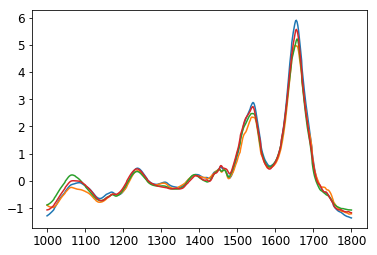

In [62]:
plt.clf()
for name, df in DATA.groupby(level = "Label"):
    
    plt.plot(df.mean(axis = 0), label = name)
    
plt.show()

In [64]:
% time

n_Folds = 2

results = dict()

for i, name in enumerate(np.unique(Y)):
    
    # Find out the ratio of positive classes to negative to scale positive weights.
    # Allows for compensation of unbalanced classes without throwing away data.
    
    pos_ratio = 1/(np.sum(Y_b[:,i])/Y_b[:,i].shape[0])
    
    print(np.unique(Y_b[:,i]))

    #classifier = xgb.XGBClassifier(objective = "binary:logistic", n_classes = 2, n_jobs = -1, scale_pos_weight = pos_ratio)
    
    classifier = RandomForestClassifier(n_jobs = -1)

    clf = GridSearchCV(classifier, param_grid  = param_dist
                             , scoring = scorers, refit = "ROC_AUC"
                             , error_score = 0, verbose = 3
                             , n_jobs = -1, return_train_score = True
                             , cv = KFold(n_splits = 2, shuffle = True).split(X)
                             #, cv = GroupKFold(n_Folds).split(X, Y_b[:,i], DATA.reset_index()["Core"])
                             #, cv = GroupShuffleSplit(n_Folds, train_size = 0.3).split(X, Y, DATA.reset_index()["Core"])
                             #, cv = LeavePGroupsOut(50).split(X, Y_b[:,i], groups)
                            )
    
    results[name] = clf.fit(X,Y_b[:,i])

Wall time: 0 ns
[0 1]
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   45.2s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 15.5min finished


[0 1]
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   45.2s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 15.7min finished


[0 1]
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   52.6s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 17.9min finished


[0 1]
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   40.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 11.3min finished


In [66]:
output

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
ATM  0      32.225265      0.705517         4.553718        0.168136   
     1     142.580228      3.655808         7.116501        0.091169   
     2     843.574777     23.069206        13.076108        4.536196   
CAM  0      33.890146      0.664896         4.234485        0.018495   
     1     157.275687      2.117943         6.885093        0.029054   
     2     861.383396      0.964271        17.123352        1.226520   
OE19 0      38.625375      0.040219         4.283264        0.010348   
     1     171.351120      1.405045         6.827078        0.055481   
     2     988.760238     10.142449        15.759168        0.393682   
OE21 0      23.479728      2.686817         4.873387        0.149991   
     1     105.388484      2.954125         6.744829        0.555844   
     2     606.496273     12.655087        10.520770        2.716835   

       param_n_estimators                 params  split0_test_ROC_AUC  \
ATM  0                 10   {'n_estimators': 10}             0.914427   
     1                 50   {'n_estimators': 50}             0.944161   
     2                500  {'n_estimators': 500}             0.945528   
CAM  0                 10   {'n_estimators': 10}             0.998437   
     1                 50   {'n_estimators': 50}             0.998903   
     2                500  {'n_estimators': 500}             0.999010   
OE19 0                 10   {'n_estimators': 10}             0.998528   
     1                 50   {'n_estimators': 50}             0.998983   
     2                500  {'n_estimators': 500}             0.999094   
OE21 0                 10   {'n_estimators': 10}             0.976445   
     1                 50   {'n_estimators': 50}             0.984950   
     2                500  {'n_estimators': 500}             0.985510   

        split1_test_ROC_AUC  mean_test_ROC_AUC  std_test_ROC_AUC  ...  \
ATM  0             0.914882           0.914654          0.000228  ...   
     1             0.944690           0.944425          0.000264  ...   
     2             0.949415           0.947472          0.001944  ...   
CAM  0             0.998538           0.998487          0.000050  ...   
     1             0.998978           0.998940          0.000037  ...   
     2             0.999166           0.999088          0.000078  ...   
OE19 0             0.998532           0.998530          0.000002  ...   
     1             0.998921           0.998952          0.000031  ...   
     2             0.998944           0.999019          0.000075  ...   
OE21 0             0.973871           0.975158          0.001287  ...   
     1             0.980909           0.982929          0.002020  ...   
     2             0.983886           0.984698          0.000812  ...   

        std_train_Precision  split0_test_Sensitivity  split1_test_Sensitivity  \
ATM  0         0.000000e+00                 0.828911                 0.829868   
     1         0.000000e+00                 0.888381                 0.889414   
     2         0.000000e+00                 0.891125                 0.898866   
CAM  0         1.256769e-07                 0.998096                 0.998572   
     1         0.000000e+00                 0.998927                 0.999273   
     2         0.000000e+00                 0.999142                 0.999569   
OE19 0         1.080941e-05                 0.997978                 0.998162   
     1         0.000000e+00                 0.998717                 0.998941   
     2         0.000000e+00                 0.998891                 0.998962   
OE21 0         0.000000e+00                 0.952984                 0.947920   
     1         0.000000e+00                 0.969982                 0.961901   
     2         0.000000e+00                 0.971067                 0.967843   

        mean_test_Sensitivity  std_test_Sensitivity  rank_test_Sensitivity  \
ATM  0               0.829389          

In [65]:
output = pd.concat({label: pd.DataFrame(results[label].cv_results_) for label in np.unique(Y)})

output.to_csv(r"C:\Users\Conor\Documents\Referee_Comment_Results\New_Results_05_02_19\Unbalanced_Data.csv")

df = pd.DataFrame(results["ATM"].cv_results_)

plt.clf()
threedee = plt.figure().gca(projection='3d')
threedee.scatter(df["param_colsample_bytree"], df["param_learning_rate"], df["mean_test_Precision"])
plt.show()